
# Project 3: Sentiment Analysis on Artificial Intelligence Discussion by Mo Gawdat - Part 2

# 1. Pre-processing

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import auc, roc_auc_score, RocCurveDisplay 

%matplotlib inline

In [24]:
df = pd.read_csv('data/cleaned_comments.csv')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23137 entries, 0 to 23136
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   comment_id       23137 non-null  object 
 1   author           23132 non-null  object 
 2   likes            23137 non-null  int64  
 3   cleaned_comment  23137 non-null  object 
 4   vader_compound   23137 non-null  float64
 5   vader_label      23137 non-null  object 
 6   label            23137 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 1.2+ MB


### 1.1. Tokenizer and Lemmatizer

> Pre-processing is to feature-engineering text data into format that machine can understand and learn to faciliate sentiment analysis. 

> Noises in the text data (punctuations, emojis, special characters e.g. exclamation marks) have been removed through data cleaning.

> Tokenizer is used to split the string of sentence into words/tokens. Whitespace Tokenizer is used to split words by whitespace since the words have been stripped off noises in the upstream data cleaning.  It is better than other tokenizers by regular expression, punctuations-based and Tweet.

> Lemmatization bring the word to its common base/root, meaningful for NLP.  For example, words such as 'better' and 'compassion' would not work in Stemming, while lemmatization is able to recognize these words and return to 'good' and remain as 'compassion').  While Stemming is deemed too agressive for my case study as I would like to preserve the meaning of words.  

> After tokenize and lemmatize the 'comment' column, words are joined back to its original dataframe/corpus.

In [26]:
# Instantiate Tokenizer to bring a string of texts to words
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# Apply the function to the 'cleaned_comment' column and create a new 'lemmatized text' column
df['comment'] = df['cleaned_comment'].apply(lemmatize_text)
df['comment'] = df['comment'].apply(lambda lemma: ' '.join(lemma))

In [27]:
df

,comment_id,author,likes,cleaned_comment,vader_compound,vader_label,label,comment
0,UgxRNRfy58W4Z5XzyNh4AaABAg,The Diary Of A CEO,3341,mo is back and this is honestly a conversation...,0.9673,positive,1,mo is back and this is honestly a conversation...
1,UgxRNRfy58W4Z5XzyNh4AaABAg.9qPc3Mj_li_9siUH0VwDat,erNomic,0,wisdom and compassion come with experience the...,0.9184,positive,1,wisdom and compassion come with experience the...
2,UgxRNRfy58W4Z5XzyNh4AaABAg.9qPc3Mj_li_9sddl685hN7,Puppet Master,0,yea and i noticed he has his notebook out for ...,0.4404,positive,1,yea and i noticed he ha his notebook out for y...
3,UgxRNRfy58W4Z5XzyNh4AaABAg.9qPc3Mj_li_9s3h9LwfsIl,TrueNemesisPrime,0,jacque fresco was clearly years ahead of the c...,0.8905,positive,1,jacque fresco wa clearly year ahead of the cur...
4,UgxRNRfy58W4Z5XzyNh4AaABAg.9qPc3Mj_li_9rPcFroz8Xo,Student of Life,0,well said,0.2732,positive,1,well said
...,...,...,...,...,...,...,...,...
23132,UgwA5WFFLf95BBumMDF4AaABAg,Vicki,0,they truly are delusional,0.4404,positive,1,they truly are delusional
23133,UgzJamxrhuLi7r1tG154AaABAg,Mowlid Ahmed barre,6,it is beyond an emergency,-0.3818,negative,0,it is beyond an emergency
23134,UgySod5MqpsBVy_PMrx4AaABAg,awkwardmochi.,5,thank you for this video a very needed convers...,0.3612,positive,1,thank you for this video a very needed convers...
23135,UgycItCNgwKO5RmnNaB4AaABAg,Alex Z,0,disgusting trying to destroy the traditional f...,-0.7845,negative,0,disgusting trying to destroy the traditional f...


## 1.2 Stop Words

> Stop words are top occurring words in documents that it does not make any siginificance to the prediction of target variable Y.

> Noise in the text data that removal of stop words could improve the predictability of model. 

In [28]:
# Print English stopwords.
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [29]:
# Remove stopwords from 'comment' column
def remove_stop_words(x):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(x)
    non_stop_words = [token for token in tokens if token.lower() not in stop_words]
    return non_stop_words

In [30]:
# Apply the stop word removal function and join the remaining tokens
df['comment'] = df['comment'].apply(remove_stop_words)
df['comment'] = df['comment'].apply(lambda tokens: ' '.join(tokens))

In [37]:
df

,comment_id,author,likes,cleaned_comment,vader_compound,vader_label,label,comment
0,UgxRNRfy58W4Z5XzyNh4AaABAg,The Diary Of A CEO,3341,mo is back and this is honestly a conversation...,0.9673,positive,1,mo back honestly conversation missed please sh...
1,UgxRNRfy58W4Z5XzyNh4AaABAg.9qPc3Mj_li_9siUH0VwDat,erNomic,0,wisdom and compassion come with experience the...,0.9184,positive,1,wisdom compassion come experience lack today w...
2,UgxRNRfy58W4Z5XzyNh4AaABAg.9qPc3Mj_li_9sddl685hN7,Puppet Master,0,yea and i noticed he has his notebook out for ...,0.4404,positive,1,yea noticed ha notebook time thats good interv...
3,UgxRNRfy58W4Z5XzyNh4AaABAg.9qPc3Mj_li_9s3h9LwfsIl,TrueNemesisPrime,0,jacque fresco was clearly years ahead of the c...,0.8905,positive,1,jacque fresco wa clearly year ahead curve venu...
4,UgxRNRfy58W4Z5XzyNh4AaABAg.9qPc3Mj_li_9rPcFroz8Xo,Student of Life,0,well said,0.2732,positive,1,well said
...,...,...,...,...,...,...,...,...
23132,UgwA5WFFLf95BBumMDF4AaABAg,Vicki,0,they truly are delusional,0.4404,positive,1,truly delusional
23133,UgzJamxrhuLi7r1tG154AaABAg,Mowlid Ahmed barre,6,it is beyond an emergency,-0.3818,negative,0,beyond emergency
23134,UgySod5MqpsBVy_PMrx4AaABAg,awkwardmochi.,5,thank you for this video a very needed convers...,0.3612,positive,1,thank video needed conversation indeed
23135,UgycItCNgwKO5RmnNaB4AaABAg,Alex Z,0,disgusting trying to destroy the traditional f...,-0.7845,negative,0,disgusting trying destroy traditional family


In [32]:
df.to_csv('data/pre_modelling.csv', index=False)

## 1.3 Function for model evaluation

In [33]:
# Create a function for model evaluation metrics
def model_metrics(model, X_test, y_test):
    y_prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_prediction)
    print('Accuracy score: ', round(accuracy,4))
    precision = precision_score(y_test, y_prediction)
    print('Precision score: ', round(precision,4))
    recall = recall_score(y_test, y_prediction)
    print('Recall score: ', round(recall,4))
    f1 = f1_score(y_test, y_prediction)
    print('F1 score: ', round(f1,4))

## 1.4 Baseline Accuracy

> Baseline accuracy is benchmark against to assess whether my model performance is better than null model. 

In [12]:
# Baseline Accuracy as null model reference point
df = pd.read_csv('data/pre_modelling.csv')
df['label'].value_counts(normalize=True)

0    0.528374
1    0.471626
Name: label, dtype: float64

> There are balanced dataset between positive and negative.  Hence no further action is required.

> Next step is to train/test split the dataset into training and testing sets for vectorization, modelling and evaluation of performance.  

## 1.5 Train/Test Split

> Scikit-Learn Library 'train_test_split' is used to to split dataset into two parts, training sets and testing sets.

> As my dataset consists of over 23,000 rows, there is sufficient for testing hence I chose to split 20% of the dataset for testing while the rest 80% for training the dataset.

> Classification label 'positive' is set as 1, aim to assess whether comments are more receptive towards discussions on AI. 

In [38]:
# First, set up X and y.  
X = df['comment']
y = df['label']

In [39]:
# Split the data into the training and testing sets by 70:30.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [40]:
# Check the shape of training and testing sets.
print(f'The size of training and testing sets after Train/Test Split:')
print(f'X_train size: {X_train.shape}')
print(f'X_test size: {X_test.shape}')
print(f'y_train size: {y_train.shape}')
print(f'y_train size: {y_test.shape}')

The size of training and testing sets after Train/Test Split:
X_train size: (18509,)
X_test size: (4628,)
y_train size: (18509,)
y_train size: (4628,)


# 3. Modelling

## 3.1 TF-IDF Vectorizer and Multinomial Naive Bayes Model 

> TF-IDF Vectorizer is chosen over Bag-of-Word, CountVectorizer or One Hot Encoding because:
> 1. Discrete text representation in matrix form
> 2. TF-IDF assigns weights to words that are important to one document, relative to all other documents.
> 3. Premised on occurence of words in one document but don't occur in many other documents, contain more predictive power than those appearing in almost all docs.
> 4. Penalize highly frequent words and low frequency words, hence reducing noise.  In a way, it has already performed Stop Words 

> MultinomialNB implements the naive Bayes algorithm for multinomially distributed data. It works best on text data classification for sentiment analysis because data can be represented by TF-IDF vector counts. And it is simple to implement with good interpretability. 

In [41]:
# Instantiate pipeline for TF-IDF Vectorizer as transformer and MultinomialNB classifier
pipe1 = SklearnPipeline([
    ('tvec', TfidfVectorizer()),  # Convert text to vectors
    ('nb', MultinomialNB())     # Multinomial Naive Bayes classifier
])

In [45]:
# Set pipeline parameters for fine-tuning hyperparameters
pipe1_params = {'tvec__min_df': [2],
                'tvec__max_df': [0.98],
                'tvec__ngram_range': [(1,1), (1,2)],
                'nb__alpha': [ 10, 50]}

In [46]:
# Instantiate GridSearchCV and fill in the hyperparameter tuning
gs1 = GridSearchCV(pipe1,
                   param_grid = pipe1_params, 
                   cv=5)      # 5-fold cross-validation.

In [47]:
# Train model
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [10, 50], 'tvec__max_df': [0.98],
                         'tvec__min_df': [2],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

> Model Evaluation

In [48]:
# Evaluate train model
model_metrics(gs1, X_train, y_train)

Accuracy score:  0.8419
Precision score:  0.8248
Recall score:  0.8441
F1 score:  0.8343


In [49]:
# Validate with test set 
model_metrics(gs1, X_test, y_test)

Accuracy score:  0.7928
Precision score:  0.7661
Recall score:  0.8071
F1 score:  0.7861


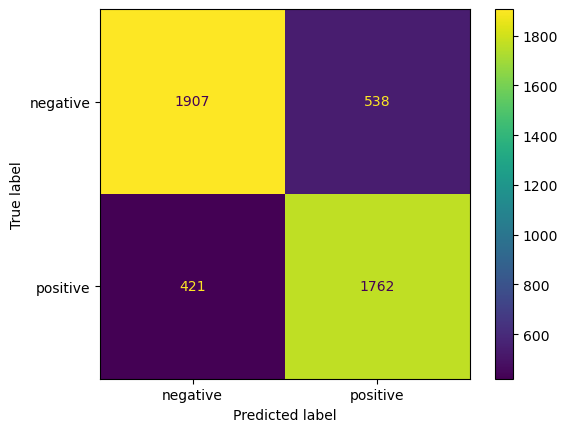

In [50]:
# View confusion matrix
y_pred_gs1 = gs1.predict(X_test)
cm = confusion_matrix(y_test, y_pred_gs1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot()

In [51]:
# Check ROC-AUC and the estimators' parameters
print(f'ROC-AUC score: {roc_auc_score(y_test, gs1.predict_proba(X_test)[:,1])}')
print(gs1.best_estimator_)

ROC-AUC score: 0.8752560921116603
Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.98, min_df=2)),
                ('nb', MultinomialNB(alpha=10))])


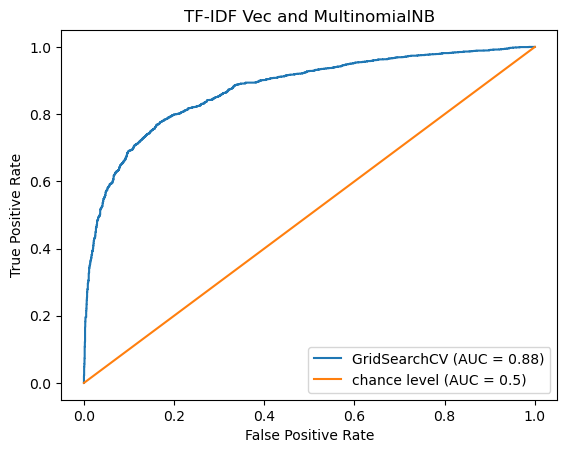

In [52]:
# Plot ROC curve
RocCurveDisplay.from_estimator(gs1, X_test, y_test)
plt.plot([0, 1], [0, 1], label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('TF-IDF Vec and MultinomialNB')
plt.legend()
plt.show()

> Interpretation:
> 1. the training score and test score of metrics vary within the range of 5%-7%, hence MultinomialNB model perform well at alpha 10 generated through GridSearchCV, where True Positive Rate is optimized.
> 2. ROC-AUC score is 0.84 which is pretty good.
> 3. As my data set is relatively balanced with 53% negative '0' vs 47% positive '1', hence accuracy score can give a good picture of model performance.
> 4. This model can be used to test on other video comments. However, I would like to test the training sets on other models to see if any better model. 

## 3.2 TF-IDF Vectorizer and Random Forest Model

> Random forest model operate as an ensemble of individual model (tree) through random resampling. Each model spits out a class prediction and the class with the most votes becomes the model’s prediction, for classification problem.  It average out the variance hence low bias and moderate variance.

> Premised on the wisdom of crowds.  Bagged decisions trees tend to outperform single decision trees.  

> Require little pre-processing and allow parallel runs, hence it is great with high dimensionality.  It might work well for my sentiment analysis because Youtube video comments are unstructured texts, and the dimension can get over-blown if vectorize/OHE. 

In [53]:
# Instantiate pipeline for TF-IDF vectorizer as transformer and RandomForest as classifier
pipe2 = SklearnPipeline([('tvec', TfidfVectorizer()),
                         ('rf', RandomForestClassifier())])

In [54]:
# Setting pipe parameters for fine-tuning 
pipe2_params = {'tvec__min_df': [2],
                'tvec__max_df': [0.98],
                'tvec__ngram_range': [(1,1), (1,2)],
                'rf__n_estimators': [100, 150, 200],
                'rf__max_depth': [5, 10, 20, 25]}

In [55]:
# Instantiate Gridsearch
gs2 = GridSearchCV(pipe2,
                   param_grid = pipe2_params,
                   cv=5)

In [56]:
# Train model
gs2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [5, 10, 20, 25],
                         'rf__n_estimators': [100, 150, 200],
                         'tvec__max_df': [0.98], 'tvec__min_df': [2],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

> Model Evaluation

In [57]:
# Evaluate train model
model_metrics(gs2, X_train, y_train)

Accuracy score:  0.8223
Precision score:  0.9795
Recall score:  0.6365
F1 score:  0.7716


In [58]:
# Validate with test set 
model_metrics(gs2, X_test, y_test)

Accuracy score:  0.7239
Precision score:  0.7895
Recall score:  0.5653
F1 score:  0.6588


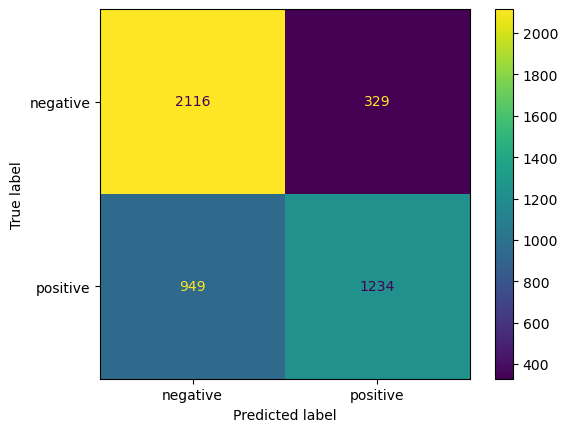

In [59]:
# View confusion matrix
y_pred_gs2 = gs2.predict(X_test)
cm = confusion_matrix(y_test, y_pred_gs2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot()

In [60]:
# Check ROC-AUC and the estimators' parameters
print(f'ROC-AUC score: {roc_auc_score(y_test, gs2.predict_proba(X_test)[:,1])}')
print(gs2.best_estimator_)

ROC-AUC score: 0.8290922512405303
Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.98, min_df=2)),
                ('rf', RandomForestClassifier(max_depth=25, n_estimators=200))])


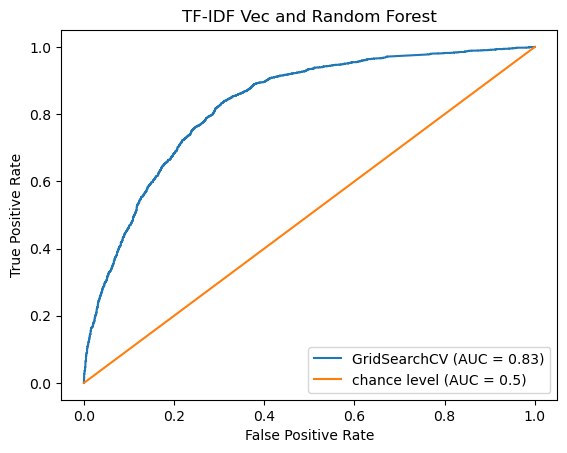

In [61]:
# Plot ROC curve
RocCurveDisplay.from_estimator(gs2, X_test, y_test)
plt.plot([0, 1], [0, 1], label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('TF-IDF Vec and Random Forest')
plt.legend()
plt.show()

> Interpretation:
> 1. Random Forest optimized through GridSearchCV, with better Precision Score. It means it predict negative comments better than Naive Bayes.
> 2. It overfits hence hyperparameters tuning (esp. add custom stop words) is required and it takes time (computer memory) to process. 
> 3. Model interpretability is not ideal, like a black box. 

In [62]:
# Extract the model's feature importances by Gini impurity 
rf = gs2.best_estimator_.named_steps['rf']
feature_importances = rf.feature_importances_

# Getting the feature names 
tvec = gs2.best_estimator_.named_steps['tvec']
feature_names = tvec.get_feature_names_out()

# display the feature importances
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
fi_df.sort_values(by='importance', ascending=False, inplace=True)
fi_df.head(10)

,feature,importance
6275,love,0.027780
10494,thank,0.021835
1006,best,0.018766
6155,like,0.018460
5574,intelligence,0.017658
4612,great,0.016923
4530,good,0.014737
4507,god,0.012881
5575,intelligent,0.012595
10499,thanks,0.010834


## 3.3 TF-IDF Vectorizer and Logistic Regression Model

> Logistic Regression works well on classification of sentiment analysis with its interpretability.

> It can interpret model coefficients as indicators of feature importance.

> Regularization to avoid overfitting. 

In [63]:
# Instantiate pipeline for TF-IDF vectorizer as transformer and Logistic Regression as classifier
pipe3 = SklearnPipeline([('tvec', TfidfVectorizer()),
                         ('lr', LogisticRegression())])

In [64]:
# Setting pipe parameters for fine-tuning 
pipe3_params = {'tvec__min_df': [2],
                'tvec__max_df': [0.98],
                'tvec__ngram_range': [(1,1), (1,2)],
                'lr__C': [0.5,1,3,5,10],
                'lr__solver': ['liblinear'],
                'lr__max_iter': [1000,2000]}

In [65]:
# Instantiate Gridsearch
gs3 = GridSearchCV(pipe3,
                   param_grid = pipe3_params,
                   cv=5)

In [66]:
# Train model
gs3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.5, 1, 3, 5, 10],
                         'lr__max_iter': [1000, 2000],
                         'lr__solver': ['liblinear'], 'tvec__max_df': [0.98],
                         'tvec__min_df': [2],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

> Model Evaluation

In [67]:
# Evaluate train model
model_metrics(gs3, X_train, y_train)

Accuracy score:  0.9373
Precision score:  0.9439
Recall score:  0.9218
F1 score:  0.9327


In [68]:
# Validate with test set 
model_metrics(gs3, X_test, y_test)

Accuracy score:  0.8442
Precision score:  0.858
Recall score:  0.8026
F1 score:  0.8293


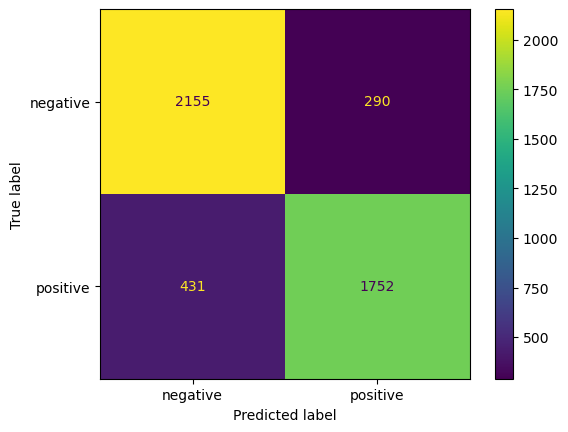

In [69]:
# View confusion matrix
y_pred_gs3 = gs3.predict(X_test)
cm = confusion_matrix(y_test, y_pred_gs3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot()

In [70]:
# Check ROC-AUC and the estimators' parameters
print(f'ROC-AUC score: {roc_auc_score(y_test, gs3.predict_proba(X_test)[:,1])}')
print(gs3.best_estimator_)

ROC-AUC score: 0.9173587125651179
Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.98, min_df=2)),
                ('lr',
                 LogisticRegression(C=5, max_iter=1000, solver='liblinear'))])


> Interpretation:
> 1. Features dimension can get overblown.
> 2. Require texts preprocessing to train model. As there are more noises in real case, it can get time-consuming. 
> 3. Assume words are independant, which are not the case.  Words are highly correlated.
> 4. Overfitting hence having challenges to generalize to new data. 

## 3.4 TF-IDF Vectorizer and Support Vector Machine Model

> Support Vector Machine (Linear) is best suited for sentiment analysis and text classification as it deals with large sparse data vectors. Able to handle a high dimensional features.

> SVM text classification problems tend to be linearly separable and it takes less training time.

In [71]:
# Instantiate pipeline for TF-IDF vectorizer as transformer and Support Vector Machine as classifier
pipe4 = SklearnPipeline([('tvec', TfidfVectorizer()),
                         ('lsvc', LinearSVC())])

In [72]:
# Setting pipe parameters for fine-tuning 
pipe4_params = {'tvec__min_df': [2],
                'tvec__max_df': [0.98],
                'tvec__ngram_range': [(1,1), (1,2)],
                'lsvc__max_iter': [20000,25000]}

In [73]:
# Instantiate Gridsearch
gs4 = GridSearchCV(pipe4,
                   param_grid = pipe4_params,
                   cv=5)

In [74]:
# Train model
gs4.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lsvc', LinearSVC())]),
             param_grid={'lsvc__max_iter': [20000, 25000],
                         'tvec__max_df': [0.98], 'tvec__min_df': [2],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

> Model Evaluation

In [75]:
# Evaluate train model
model_metrics(gs4, X_train, y_train)

Accuracy score:  0.9527
Precision score:  0.9572
Recall score:  0.9419
F1 score:  0.9495


In [76]:
# Validate with test set 
model_metrics(gs4, X_test, y_test)

Accuracy score:  0.8412
Precision score:  0.8501
Recall score:  0.8053
F1 score:  0.8271


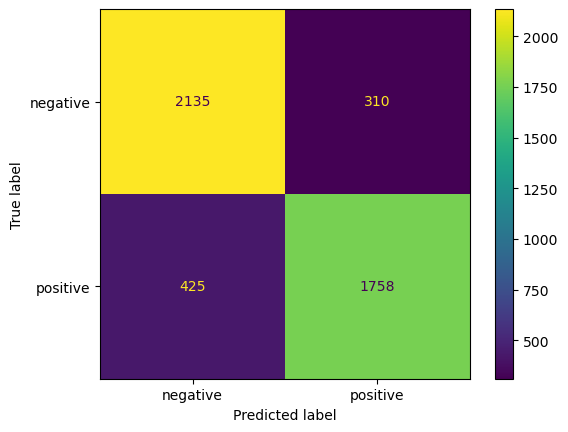

In [77]:
# View confusion matrix
y_pred_gs4 = gs4.predict(X_test)
cm = confusion_matrix(y_test, y_pred_gs4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot()

In [78]:
# Check estimators' parameters
print(gs4.best_estimator_)

Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.98, min_df=2)),
                ('lsvc', LinearSVC(max_iter=20000))])


Interpretation: 
1. The assumption that most the features are irrelevant, as aggressive feature selection tends to result in a loss of information.
2. Overfitting issues hence foresee to have difficulty to generalize to new data.

# 4. Conclusions
Based on my analysis and comparison of the 4 models, Multinomial Naive Bayes with TF-IDF Vectorizer fetchs the best results.  Other models seem to be overfitting.  

Accuracy is a valid choice of evaluation for sentiment analysis on Mo Gawdat's Youtube videos because the datasets are fairly well balanced (53% negative vs 47% positive comments) and not skewed. Hence accuracy is a good measurement of true positives which is the problem statement trying to solve, i.e. those positive comments are correctly labeled so that the assessment of positive feedback from online users allow Mo Gawdat to assess the type of topics online listeners preferred.   

Precision score is also considered as we cannot rely on accuracy score alone.  Precision is a useful metric in my case study where False Positive is a concern as I do not want to falsely classify negative comments as positive which will give a wrong picture on the receptiveness of online listeners.

| Models                      | ROC-AUC Score| Accuracy Score                | Precision Score                  | Review                                                          |
|---------------------------------|--------- |-------------------------------|----------------------------------|-----------------------------------------------------------------|
| **Multinomial Naive Bayes**         |  0.8752  | Train: 0.8419<br>Test: 0.7928  | Train: 0.8248<br>Test: 0.7661 | The most balanced model. **Best Model**|                           |    
| Random Forest                   |  0.8291 | Train: 0.8223<br>Test: 0.7239  | Train: 0.9795<br>Test: 0.7895 | Highest precision score, but massively overfit.                    |   
| Logistic Regression             |  0.9174 | Train: 0.9373<br>Test: 0.8442  | Train: 0.9439<br>Test: 0.8580 | Overfit                                                            |
| Support Vector Machine (Linear) |    -  | Train: 0.9527<br>Test: 0.8412 | Train: 0.9572<br>Test: 0.8501 | Highest accuracy score, but accuracy and precision scores overfitting.|



# 5. Recommendations and Future works
1. Train the best classification model (Multinomial Naive Bayes) on more Youtube videos to improve predictive capability of the model.
2. Explore other classifier model that can categorize emojis which would be useful to have a more hollistic view of sentiment analysis. As emojis which can also be a form of expression.
3. Explore Vader lexicon for any updates on social media buzzwords to improve prediction power. 
4. Continue to exhaust on hyperparameters tuning, and then proceed to gather more data for feature engineering, but it require more time invested to get improved performance.
5. Expand the model to track sales of his book which relates to AI. The book titled 'Scary Smart: The Future of Artificial Intelligence and How You Can Save Our World' which was released in 2021.  It can be done as a classification project to assess if the positive comments on Youtube lead to increase in his book sales.